In [1]:
from haplogone import VCF

In [2]:
sample = VCF("../../bioinf_semester_project/data/sample_2/gatk_called.vcf")
sample.read().count_baf().segment_baf()
sample

VCF(
	input_file='../../bioinf_semester_project/data/sample_2/gatk_called.vcf',
	path_to_centromeres_file='centromeres.bed',
	baf_freq_threshold=0.95,
	segment_size_threshold=1000000.0,
	segmentation_shuffles=1000,
	segmentation_p=0.01,
	validation_shuffles=1000,
	validation_p=0.01
)

In [3]:
sample.bed

In [4]:
sample.create_bed().save_bed().bed

,#chrom,chromStart,chromEnd,name
0,chr10,133263092,133626299,LOH
1,chr11,69048902,69773961,LOH
2,chr11,65853822,65919008,LOH
3,chr12,120655826,121274274,LOH
4,chr12,108293672,108623874,LOH
5,chr17,3732474,3745920,LOH
6,chr17,4892324,5034672,LOH
7,chr17,75762957,76120342,LOH
8,chr19,42730043,43015290,LOH
9,chr19,43802424,44108078,LOH


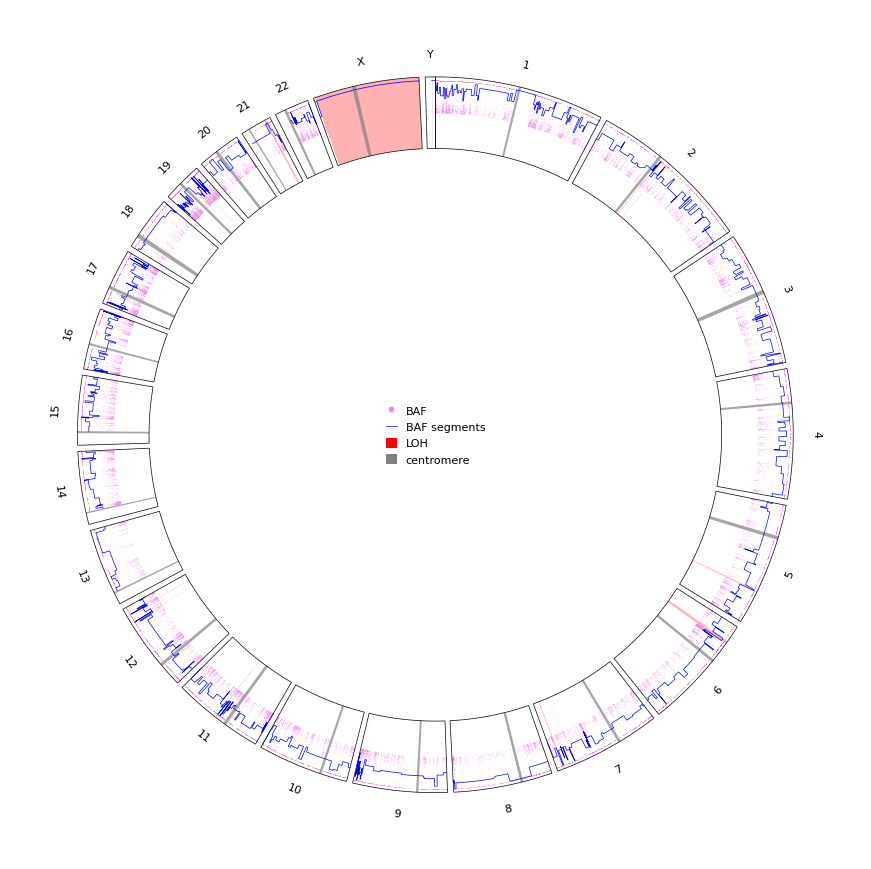

In [5]:
sample.plot_chromosomes_circular(save_plot=True)
sample.plot_chromosomes_circular()

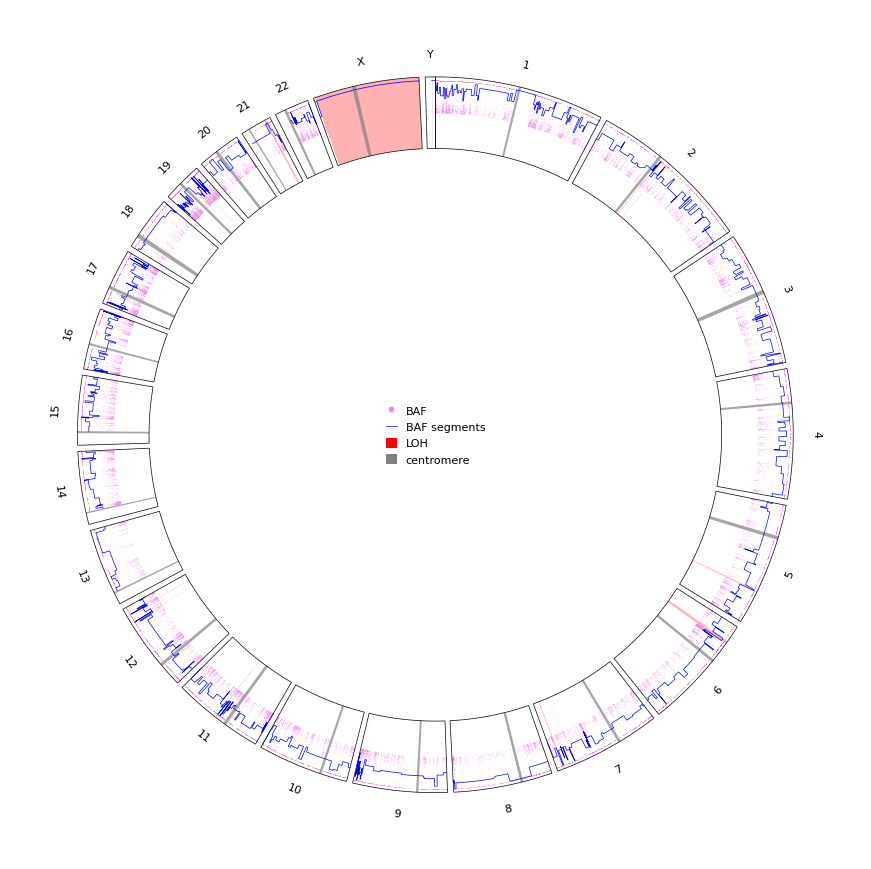

In [6]:
sample.generate_report()

In [7]:
sample.plot_chromosomes()